In [8]:
# Pyspark 설치
# https://dev.to/kinyungu_denis/to-install-apache-spark-and-run-pyspark-in-ubuntu-2204-4i79

In [6]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPyspark

In [7]:
import pyspark.sql.functions as F
import os
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
os.environ["SPARK_LOCAL_IP"]='127.0.0.1'
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext._conf.getAll()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/15 15:51:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', 'localhost'),
 ('spark.driver.port', '35769'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.app.id', 'local-1678863098461'),
 ('spark.app.submitTime', '1678863097662'),
 ('sp

In [11]:
# 파이스파크에는 자체적으로 데이터프레임을 생성한다
data_path = 'creditcard.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)
labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove(labelColumn)
print(numericCols)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [12]:
df.show(2)

23/03/15 15:57:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
|Time|              V1|                 V2|              V3|               V4|                V5|                 V6|                 V7|                V8|                V9|               V10|               V11|               V12|               V13|               V1

In [13]:
# 파이스파크에는 판다스로 변형한다.
df.toPandas().head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [20]:
# 모델 학습을 위해, 벡터 추출 필요
stages = []
assemblerInputs = numericCols
# features 벡터로 변환한 칼럼을 알 수 있도록, 어셈블러에 대한 입력을 정의
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features")
stages += [assembler]
dfFeatures = df.select(F.col(labelColumn).alias('label'),*numericCols)

In [24]:
normal = dfFeatures.filter("Class==0").sample(withReplacement=False, fraction=0.5, seed=2020)
anomaly = dfFeatures.filter("Class == 1")
normal_train, normal_test = normal.randomSplit([0.8,0.2], seed = 2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8,0.2], seed=2020)

In [25]:
# 이상징후, 정상징후 융합
train = normal_train.union(anomaly_train)
test = normal_test.union(anomaly_test)

## 파이프라인 생성

In [26]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(dfFeatures)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)

# 컬럼을 따로 묶는다... ??
selectedCols = ['label','features'] + numericCols
train = train.select(selectedCols)
test = test.select(selectedCols)
print("Training Dataset Count: ", train.count())
print("Test Dataset Count: ", test.count())

Training Dataset Count:  114161


Test Dataset Count:  28465


## 모델 정의

In [30]:
lr = LogisticRegressionPyspark(featuresCol='features', labelCol='label', maxIter=10)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary
pyspark_auc_score = trainingSummary.areaUnderROC


In [35]:
predictions = lrModel.transform(test)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
evaluations = lrModel.evaluate(test)
accuracy = evaluations.accuracy

print(f"AUC Score: {roc_auc_score(y_pred,y_true):.3f}") #sckit-learn의 auc score, 사이킷런에서는 85%였는데 크게 증가했다.
print(f"PySpark AUC Score: {pyspark_auc_score:.3%}")    #pyspark의 auc score
print(f"Accuracy score: {accuracy:.3f}")                #sckit-learn에서는 98%였는데 1% 증가했다

AUC Score: 0.947
PySpark AUC Score: 98.335%
Accuracy score: 0.999


## Visualization

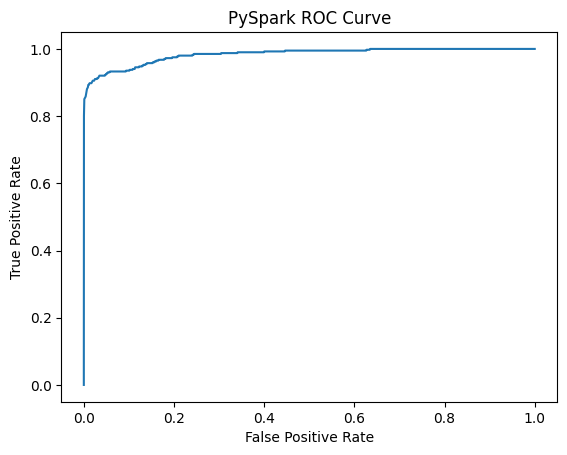

In [36]:
# Auc score가 즉 Auc area(Area under the Roc Curve)이다. 따라서, 면적은 0.98335이다.
pyspark_roc = trainingSummary.roc.toPandas()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PySpark ROC Curve')
plt.plot(pyspark_roc['FPR'],pyspark_roc['TPR'])

Text(0.5, 23.52222222222222, 'Predicted')

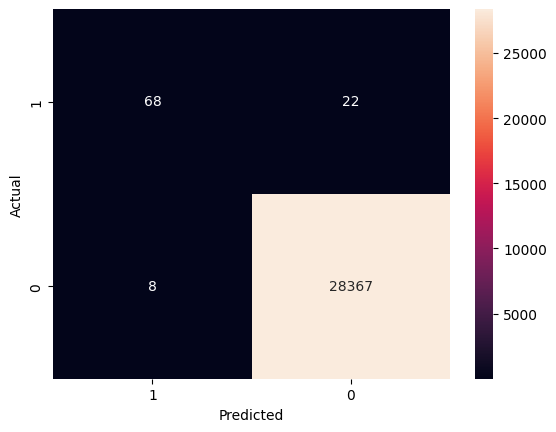

In [37]:
# 이상징후(1)만 두고보면, 이상징후 예측 정확도는 (68/90)*100 = 75% 이다. sklearn에서는 (70%99)*100 = 70%이다.
# 따라서, pyspark가 더 높은 성능 잠재력을 가지고 있다

conf_matrix = confusion_matrix(y_true, y_pred)
ax  = sns.heatmap(conf_matrix, annot=True, fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')